<a href="https://colab.research.google.com/github/abhiksark/gdg-paper-reading/blob/main/trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# The exclamation mark (!) executes shell commands within a Jupyter Notebook cell when you type (!)
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz
# wget is used to retrieve content and files from various web servers
!tar xf imagenette2-320.tgz
# tar is used to create and manipulate tar archives, 
# x specifies that we want to extract the archive, 
# and "f" specifies the name of the archive file
# contents will be extractd to the current directory

In [ ]:
!git clone https://github.com/abhiksark/gdg-paper-reading.git
# git is the command-line version control system used to manage the repository
# clone is the command used to create a copy of the repository on your local machine
# this command will create a new directory named "gdg-paper-reading" in the current working directory 
# and copy all the files and folders from the remote repository into this new directory

In [ ]:
%cd gdg-paper-reading
# %cd is a magic command used to change the current working directory

In [5]:
# importing from the week 1 repository
%mv week-1	 week_1
# rename week-1 to week_1
from week_1.vgg13 import VGG13
from week_1.vgg16 import VGG16
from week_1.vgg19 import VGG19

In [ ]:
# importing packages and  libraries
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm import tqdm

In [ ]:
def find_lr(model, train_loader, criterion, device, optimizer, init_lr=1e-8, final_lr=10, beta=0.98):
    """
    Function to find the optimal learning rate for a given model.
    """

    # Set the model to training mode
    model.train()

    # Get the number of batches in the training data
    num_batches = len(train_loader)

    # Calculate the multiplier for updating the learning rate
    mult = (final_lr / init_lr) ** (1 / num_batches)

    # Initialize the learning rate and set it in the optimizer
    lr = init_lr
    optimizer.param_groups[0]['lr'] = lr

    # Initialize the variables for tracking the loss and learning rate
    avg_loss = 0.0
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []

    # Iterate over the batches in the training data
    for inputs, labels in tqdm(train_loader, desc="Finding Learning Rate"):
        batch_num += 1

        # Move the inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Reset the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update the parameters
        optimizer.step()

        # Compute the smoothed loss
        avg_loss = beta * avg_loss + (1 - beta) * loss.item()
        smoothed_loss = avg_loss / (1 - beta ** batch_num)

        # Update the learning rate
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr

        # Record the loss and learning rate
        losses.append(smoothed_loss)
        log_lrs.append(np.log10(lr))

        # Check if the loss has increased by a factor of 4 or more
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            break

        # Update the best loss if the current loss is lower
        if smoothed_loss < best_loss or batch_num == 1:
            best_loss = smoothed_loss

    return log_lrs, losses


def validate(model, dataloader, criterion, device):
    # set model to evaluation mode
    model.eval()

    # initialize variables
    running_loss = 0.0
    correct = 0
    total = 0

    # disable gradient calculation for validation
    with torch.no_grad():
        # iterate over validation data
        for inputs, labels in tqdm(dataloader, desc="Validation"):
            # move inputs and labels to device
            inputs, labels = inputs.to(device), labels.to(device)

            # forward pass
            outputs = model(inputs)

            # compute loss
            loss = criterion(outputs, labels)

            # update loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # calculate average loss and accuracy
    avg_loss = running_loss / len(dataloader)
    accuracy = correct / total

    return avg_loss, accuracy


def visualize_kernels(model):
    # Get the weights of the first convolutional layer
    kernels = model.conv1[0].weight.detach().cpu().numpy()

    # Normalize the weights to be between 0 and 1
    min_val = kernels.min()
    max_val = kernels.max()
    normalized_kernels = (kernels - min_val) / (max_val - min_val)

    # Plot the kernels
    num_kernels = normalized_kernels.shape[0]
    num_columns = 8
    num_rows = num_kernels // num_columns + int(num_kernels % num_columns > 0)

    # Create a figure with the appropriate number of rows and columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 15))

    # Loop through each kernel and plot it on the corresponding axis
    for i, ax in enumerate(axes.flat):
        if i < num_kernels:
            # Transpose the kernel to get the correct shape for plotting
            kernel_img = normalized_kernels[i, :, :, :].transpose(1, 2, 0)
            ax.imshow(kernel_img)
        ax.axis("off")

    # Show the plot
    plt.show()

# Train the model
def train(model, dataloader, optimizer, criterion, device, scheduler=None):
    
    # Set the model to training mode
    model.train()

    # Initialize variables to keep track of loss and accuracy
    running_loss = 0.0
    correct = 0
    total = 0

    # Loop over the data
    for inputs, labels in tqdm(dataloader, desc="Training"):
        # Move inputs and labels to the device (CPU or GPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Reset the gradients
        optimizer.zero_grad()

        # Forward pass through the model
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and update the weights
        loss.backward()
        optimizer.step()

        # Update the loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update the learning rate scheduler if one is provided
        if scheduler:
            scheduler.step()

    # Compute the average loss and accuracy for the epoch
    avg_loss = running_loss / len(dataloader)
    accuracy = correct / total

    return avg_loss, accuracy


def plot_kernels(tensor, num_cols=8):
    # Compute the number of kernels and the number of rows in the plot
    num_kernels = tensor.shape[0]
    num_rows = 1 + num_kernels // num_cols

    # Create a figure with the specified number of columns and rows
    fig = plt.figure(figsize=(num_cols, num_rows))

    # Loop over the kernels and plot each one in a separate subplot
    for i in range(num_kernels):
        # Add a new subplot to the figure
        ax1 = fig.add_subplot(num_rows, num_cols, i + 1)

        # Plot the first channel of the kernel as a grayscale image
        ax1.imshow(tensor[i][0], cmap='gray')

        # Turn off the axis labels and tick marks
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    # Adjust the spacing between the subplots
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    # Show the plot
    plt.show()

In [ ]:
# check if CUDA is available and assigns the device to either the first available CUDA device or the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define data transforms for training and validation datasets
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the data using a DataLoader
train_set = ImageFolder('./imagenette2-320/train', transform=train_transform)
val_set = ImageFolder('./imagenette2-320/val', transform=val_transform)

train_loader = DataLoader(train_set, batch_size=32,
                          shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=4)

# Define the model and move to device
model = VGG13(num_classes=10)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Define cyclic learning rate schedule
max_lr = 0.01
base_lr = 0.001
step_size = len(train_loader) * 2
# clr = optim.lr_scheduler.CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr, step_size_up=step_size)

In [ ]:
# Run the learning rate finder
log_lrs, losses = find_lr(model, train_loader, criterion, device, optimizer)

# Plot the learning rate vs. loss
plt.figure()
plt.plot(log_lrs, losses)
plt.xlabel("Log10 Learning Rate")
plt.ylabel("Smoothed Loss")
plt.title("Learning Rate vs. Loss")
plt.show()

In [ ]:
# Main training and validation loop
num_epochs = 20
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(
        model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

# Plotting the training and validation loss
plt.figure()
plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss history")
plt.legend()
plt.show()

# Plotting the training and validation accuracy
plt.figure()
plt.plot(train_acc_history, label="Train Accuracy")
plt.plot(val_acc_history, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy history")
plt.legend()
plt.show()

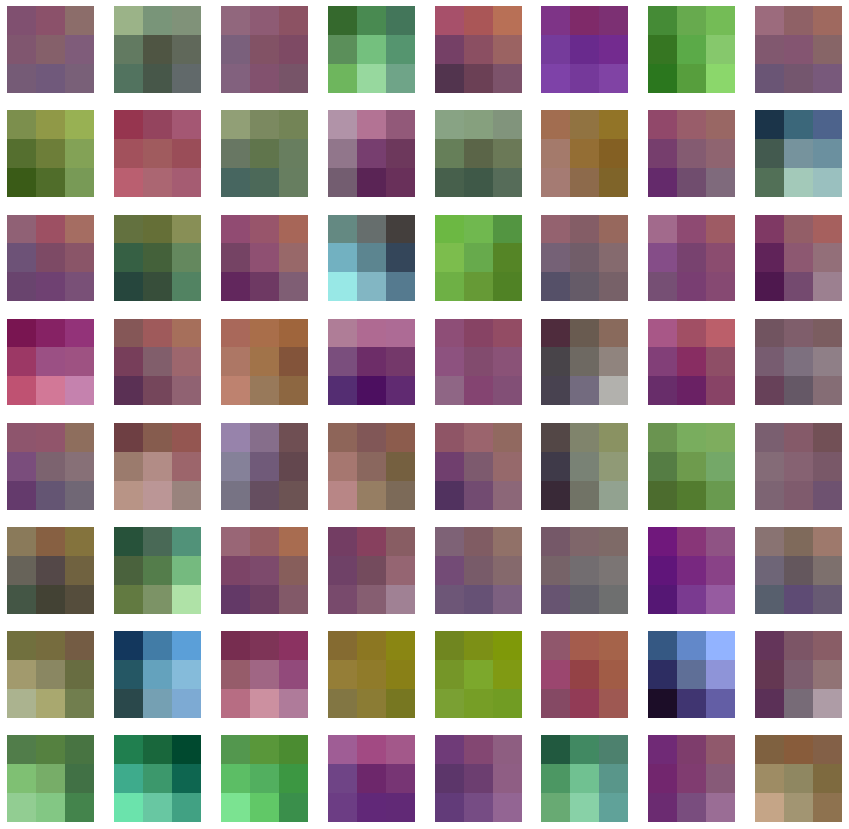

In [27]:
visualize_kernels(model)

In [21]:
# Get the weights of the first Conv2d layer in the conv5 block
weights = model.conv1[0].weight.detach().cpu()

In [23]:
weights = model.conv1[0].weight.detach().cpu()

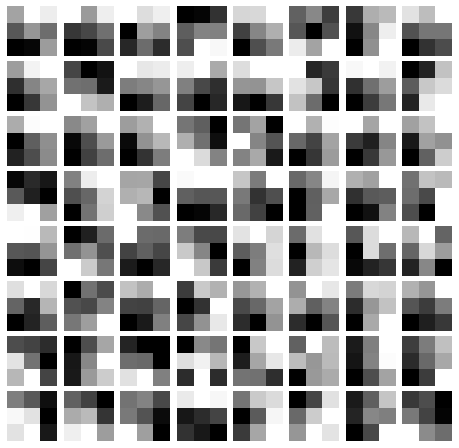

In [24]:
# Normalize the weights for visualization
normalized_weights = (weights - weights.min()) / \
    (weights.max() - weights.min())

# Visualize the kernels of the first Conv2d layer in the conv5 block
plot_kernels(normalized_weights)

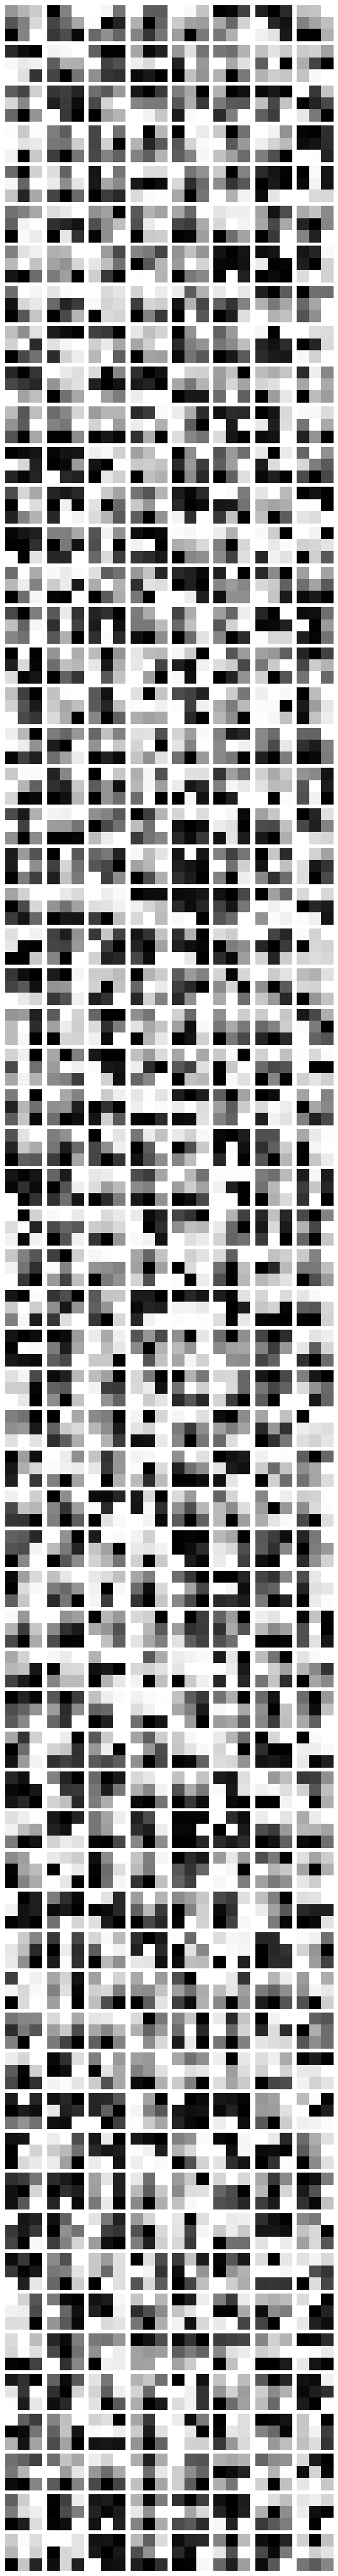

In [25]:
weights = model.conv5[0].weight.detach().cpu()

# Normalize the weights for visualization
normalized_weights = (weights - weights.min()) / \
    (weights.max() - weights.min())

# Visualize the kernels of the first Conv2d layer in the conv5 block
plot_kernels(normalized_weights)